<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li></ul></li><li><span><a href="#Load-folds" data-toc-modified-id="Load-folds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load folds</a></span><ul class="toc-item"><li><span><a href="#Incountry-folds-+-loc_dict" data-toc-modified-id="Incountry-folds-+-loc_dict-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Incountry folds + loc_dict</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li><li><span><a href="#OOC-folds" data-toc-modified-id="OOC-folds-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>OOC folds</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Urban v. Rural</a></span></li></ul></li><li><span><a href="#Dumb-Baseline-Models" data-toc-modified-id="Dumb-Baseline-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dumb Baseline Models</a></span><ul class="toc-item"><li><span><a href="#Incountry:-predict-country-mean" data-toc-modified-id="Incountry:-predict-country-mean-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Incountry: predict country mean</a></span></li><li><span><a href="#Linear-Nightlights" data-toc-modified-id="Linear-Nightlights-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Nightlights</a></span></li><li><span><a href="#KNN-on-Nightlights" data-toc-modified-id="KNN-on-Nightlights-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>KNN on Nightlights</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#OOC-Keep" data-toc-modified-id="OOC-Keep-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>OOC Keep</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li><li><span><a href="#GBT-on-NL" data-toc-modified-id="GBT-on-NL-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>GBT on NL</a></span></li></ul></li><li><span><a href="#Ridge-Regression-on-Histograms" data-toc-modified-id="Ridge-Regression-on-Histograms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ridge Regression on Histograms</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li><li><span><a href="#KNN-on-Histograms" data-toc-modified-id="KNN-on-Histograms-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>KNN on Histograms</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li></ul></div>

Prerequisites:
1. Run `preprocessing/analyze_tfrecords_dhs.ipynb`.
2. Run `data_analysis/dhs.ipynb` to create the `dhs_loc_dict.pkl` and `dhs_incountry_folds.pkl`.

### clone repository (only needed when working in colab)

In [ ]:
#! git clone https://github.com/sustainlab-group/africa_poverty.git

# Imports and Constants

In [ ]:
# load autoreload to reload module before executing them 
%load_ext autoreload        
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.neighbors

# sys.path.append('/content/africa_poverty/')
from batchers import batcher, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from models.linear_model import ridge_cv
from models.knn import knn_cv_opt
from utils.analysis import calc_score, evaluate
from utils.general import load_npz
from utils.plot import scatter_preds

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = '2009-17'      # select DHS survey data          
LABEL_NAME = 'wealthpooled'   

FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
COUNTRIES = dataset_constants.DHS_COUNTRIES     # select DHS countries

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

LOGS_ROOT_DIR = '../logs/'

# Load histograms (or create if needed)

In [ ]:
# load params for histograms 


# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]

# set BAND_BIN_EDGES and BAND_BIN_CENTERS to above numpy arrays
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]

# set LABEL_BIN_EDGES and LABEL_BIN_CENTERS to above numpy arrays
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
# set order for band colors
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [ ]:
BAND_ORDER

['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']

In [ ]:
def get_batcher(tfrecord_files):

    
  
    return batcher.Batcher(
        tfrecord_files=tfrecord_files,  # path(s) to TFRecord files containing satellite images
        dataset=DATASET_NAME,           # key to MEANS_DICT with maps to dict containing the means and standard deviations calculated over the entire dataset (train + val + test),
                                        # with negative values set to 0, and ignoring any pixel that is 0 across all bands
        batch_size=128,
        ls_bands='ms',                  # 'ms': all 7 Landsat bands
        nl_band='merge',                # 'merge': single nightlights band
        label_name=LABEL_NAME,          # set label to wealthpooled
        shuffle=False,                  # don't shuffle
        augment=False,                  # don't use data augmentation
        negatives='zero',               # clip unexpected negative values to 0
        normalize=True)                 # subtract mean and divide by std_dev

In [ ]:
# file path for DHS histograms
file_path = '/content/africa_poverty/data/dhs_image_hists.npz'

# if histograms don't exist yet they are created here:
if not os.path.exists(file_path):
    # THIS REQUIRES >= 35 GB RAM
    tfrecord_paths = batcher.get_tfrecord_paths(dataset=DATASET_NAME, split='all')          # get sorted list of paths to TFRecord files (containing satellite images) 
                                                                                            # for all splits (train,val and test) from dataset 2009_17
    init_iter, batch_op = get_batcher(tfrecord_paths).get_batch()                           # get Batch object from tfrecord_paths
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)  # create histograms per image
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)

In [ ]:
result = load_npz(file_path)                # load histograms

image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

dmsp_mask = years < 2012 # set mask for years before 2012 for dmsp
viirs_mask = ~dmsp_mask   # set mask for years since 2012 for viirs

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


In [ ]:
print(labels[0:20])
nls_mean[0:20]

[-1.0193609  -1.0900525  -1.143002    1.056769    1.4540645   1.7084457
  1.7011095   1.5477132   1.5924627   1.7062892   1.2946095   0.99117357
  1.1662261  -0.955533    1.4724743   1.2454146   2.2370064   1.4742726
  0.9874123   0.15869898]


array([-0.08663332, -0.09768403, -0.1415888 , 15.228898  , 11.082343  ,
       12.646744  ,  5.0553675 , 12.907397  , 13.1522875 , 13.142543  ,
        6.4574842 ,  6.250482  ,  6.0561304 , -0.17386247,  6.625431  ,
        5.1982536 ,  6.319383  ,  5.6553717 ,  3.2829628 ,  0.91375786],
      dtype=float32)

## Split NL band

In [ ]:
# split NL band
#2nd-to-last band is DMSP, last band is VIIRS
image_hists = split_nl_hist(image_hists, years)

In [ ]:
image_hists.shape

(19669, 9, 102)

## Plot histograms

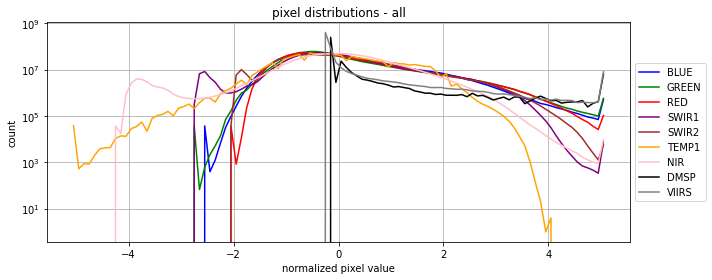

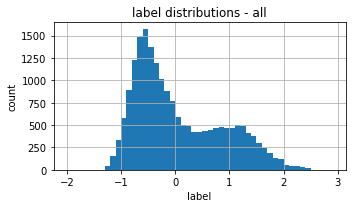

In [ ]:
# plot all histograms
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')
plot_label_hist(
    labels=labels,
    bin_edges=LABEL_BIN_EDGES,
    title='label distributions - all',
    figsize=(5, 3))

# Load folds

## Incountry folds + loc_dict

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

`incountry_folds` has the format:
```python
{
    'A': {
      'test': 
          array([   24,    32,    35, ..., 19666, 19667, 19668]),
      'train': 
          array([    0,     1,     2, ..., 19660, 19661, 19662]),
      'val': 
          array([    3,     4,     5, ..., 19624, 19625, 19663])
          }, ...
}
```


In [ ]:
with open('/content/africa_poverty/data/dhs_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)

with open('/content/africa_poverty/data/dhs_loc_dict.pkl', 'rb') as f:
    loc_dict = pickle.load(f)

incountry_group_labels = np.zeros_like(labels, dtype=np.int32)

for i, f in enumerate(FOLDS):
    # get test indices for each fold
    test_indices = incountry_folds[f]['test']
    # set label for this test in
    incountry_group_labels[test_indices] = i

## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [ ]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels
households = np.zeros(len(locs), dtype=np.int32)  # np.array of household counts


for i, loc in enumerate(locs):                          #loop through locations from histograms->np.array(lat,lon) (index and value)
    country = loc_dict[tuple(loc)]['country']           # get country for location
    country_indices[country].append(i)                  # add location index to index list for this country
    households[i] = loc_dict[tuple(loc)]['households']  # get household count for location


for i, country in enumerate(COUNTRIES):                              # loop through all DHS countries (index and value)
    country_indices[country] = np.asarray(country_indices[country])  # cast indices of all countries into numpy arrays
    indices = country_indices[country]                               # get all indices per country
    country_labels[indices] = i                                      # map indices to country index

NameError: ignored

In [ ]:
loc_dict[list(loc_dict.keys())[0]]['urban']

In [ ]:
list(loc_dict.keys())[0]

## OOC folds

In [ ]:
# create a dictionary ooc_fold with the following structure:
# 'A': {
#     'train': np.array([1, 10, 13, ...]),
#     ...
# }
ooc_folds = {
    f: {split: [] for split in SPLITS} 
    for f in FOLDS 
}

for f in FOLDS:
    surveys_dict = dataset_constants.SURVEY_NAMES[f'2009-17{f}']                                  # get dictionary {SPLIT:[COUNTRIES],..} for each fold
    for split, countries in surveys_dict.items():                                                 # get split and respective list of countries for each split
        split_indices = np.sort(np.concatenate([
                                                country_indices[country] for country in countries # get indices for each country in that split and concatenate them to numpy array
                                                ]))                   
        ooc_folds[f][split] = split_indices                                                       # set concatenated array of country indices for that fold and split in ooc_fold dictionary 

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)


pp.pprint(ooc_folds)

## Urban v. Rural

In [ ]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        
        if loc_dict[loc]['urban'] == 0:     # if location is not urban (loc_dict[loc]['urban'] == 0)
          rural_indices.append(i)           # append location index to rural indices list
        else:                               # if location is urban (loc_dict[loc]['urban'] == 1)
          urban_indices.append(i)           # append to urban indices list
    
    urban_indices = np.asarray(urban_indices)     # cast list to numpy array 
    rural_indices = np.asarray(rural_indices)     # cast list to numpy array
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}') # print distribution
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 6801	 num rural: 12868


In [ ]:
urban_indices.shape

(6801,)

# Dumb Baseline Models

## Incountry: predict country mean

In [ ]:
mean_preds = np.zeros_like(labels)                            # create empty np array to save country mean predictions to
for i, country in enumerate(COUNTRIES):                   
    indices = np.where(country_labels == i)[0]                # get indices for each country
    mean_preds[indices] = np.mean(labels[indices])            # get mean value from all labels from these indices
r2, _, _, _ = evaluate(labels, mean_preds, do_print=True)     # evaluate prediction of country mean by 4  measurements: r2 Pearson's correlation coefficient, R2 coefficient of determination, mean squared error, rank correlation coefficient 


r^2: 0.163, R^2: 0.163, mse: 0.547, rank: 0.419


In [ ]:
country_labels.shape

(19669,)

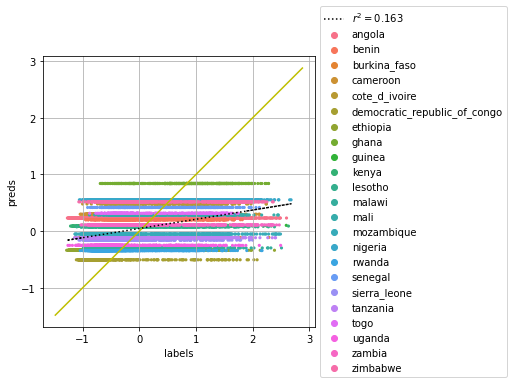

In [ ]:
scatter_preds(labels, preds=mean_preds, by_name='country', by_col=np.asarray(COUNTRIES)[country_labels])

## Linear Nightlights

In [ ]:
def linear_nl():
    '''

    Returns:    Displays a DataFrame in table style
                containing the parameters:
                    - sensor
                    - nl_type
                    - whether a weighting was used
                and the r2 value calculated with the above

    '''
    linear_nl_df = pd.DataFrame(columns=['sensor', 'nl_type', 'weighted', 'r2'])    #create DataFrame
    linear_nl_df.set_index(['sensor', 'nl_type', 'weighted'], inplace=True)        

    for sensor, mask in [('dmsp', dmsp_mask), ('viirs', viirs_mask)]:               # first get dsmp then viirs
        for nl_type, nls in [('center', nls_center), ('mean', nls_mean)]:           # first get center then mean
            for weighted, w in [(False, None), (True, households)]:                 # first non-weighted then weighted by household count
                if weighted:                            
                    w = w[mask]                                                     # when weighted only get household counts for selected sensor (masked)
                linear_nl_df.loc[(sensor, nl_type, weighted)] = calc_score(         # set r^2 values in dataframe for indices 
                    labels[mask], nls[mask], metric='r2', weights=w)                
    display(linear_nl_df)

linear_nl()

NameError: name 'pd' is not defined

## KNN on Nightlights

The following section uses leave-one-fold-out CV. This is fine for "incountry" training, but is different from the leave-one-country-out CV used for our other OOC training. For the leave-one-country-out OOC results, see the section "KNN on Histograms" below.

In [ ]:
def knn_nl(labels, years, nls_center, train_idxs, test_idxs, k=5):
    '''

    Args:
        - labels: np.array, shape [N]
        - years: np.array, shape [N]
        - nls_center: np.array, shape [N]
        - splits: dict, split (str) => np.array
        - k: int, k for KNN

    Returns:
        - Prediction
        - knn for DMSP
        - knn for VIIRS
    '''
    train_nls = nls_center[train_idxs]          # get nl train data

    # test
    test_nls = nls_center[test_idxs]            # get nl test data
    test_labels = labels[test_idxs]             # get nl test labels
    preds = np.zeros_like(test_labels)          # create empty np.array to store predictions

    knn_dmsp = sklearn.neighbors.KNeighborsRegressor(k)     # set up KNN models and set k
    knn_viirs = sklearn.neighbors.KNeighborsRegressor(k)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    # perform knn for both sensors return predictions
    for mask, model in [(dmsp_mask, knn_dmsp), (viirs_mask, knn_viirs)]:        
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, knn_dmsp, knn_viirs

In [ ]:
def knn_cv_wrapper(labels, years, nls, folds, keep=1.0, seed=None, savepath=None, verbose=False):
    '''
    Args
        - labels: np.array, shape [N]
        - years: np.array, shape [N]
        - nls: np.array, shape [N]
        - folds: dict, folds[f][split] is a np.array of indices
        - keep: float, fraction of training and validation data to use
        - seed: int, random seed
        - savepath: str, path to save predictions
        - verbose: bool, whether to print out validation performance on each fold

    Returns
        - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
            best models from the last fold
        - test_preds: np.array, shape [N]
        - ks: np.array, shape [K]
        - r2s: np.array, shape [K]
        - R2s: np.array, shape [K]
        - savepath: str, path to save npz file
    '''
    N = len(labels)               # get no of labels
    assert len(years) == N       
    assert len(nls) == N

    # set path for storing incase it isn't set yet
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)                            # create empty np.array to store predictions
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])   # create np.array with multiple different k values
    fold_keys = sorted(folds.keys())                              # get sorted list of fold keys
    r2s = np.zeros([len(fold_keys), len(ks)])                     # create empty np.array to store r^2 results for each no. of k per fold
    R2s = np.zeros([len(fold_keys), len(ks)])                     # create empty np.array to store R^2 results for each no. of k per fold

    dmsp_mask = years < 2012                                      # create mask years < 2012 for dmsp
    viirs_mask = ~dmsp_mask                                       # create mask for >=2012 for viirs                                                                           # WHY DO THEY KEEP DEFINING THIS LOCALLY? IT'S ALREADY DEFINED AS A GLOBAL VAR ABOVE???

    for i, f in enumerate(fold_keys):                             # for each fold
        if verbose:
            print(f'Runing fold {f}...')
        test_idxs = folds[f]['test']                              # set test data
        best_models = None                                        # set best_models to None

        for j, k in enumerate(ks):                                # for each no of k
            train_idxs = folds[f]['train']                        # set train data
            val_idxs = folds[f]['val']                            # set validation data

            if keep < 1:                            
                if seed is not None:                              # create a random seed
                    np.random.seed(seed)  
                num_train = int(len(train_idxs) * keep)           # get fraction size of train data
                num_val = int(len(val_idxs) * keep)               # get fraction size of validation data
                if num_train < k or num_val < k:                  
                    continue
                train_idxs = np.random.choice(                    # get random fraction from train data 
                    train_idxs, size=num_train, replace=False)
                val_tfrecord_paths = np.random.choice(
                    val_idxs, size=num_val, replace=False)        # get random fraction from val data paths                                                                           # IS THIS SUPPOSED TO BE VAL_TFRECORD_PATH INSTEAD OF VAL_IDXS?????
            
            # perform knn for both sensors and get predictions
            val_preds, knn_dmsp, knn_viirs = knn_nl(
                labels, years, nls, train_idxs=train_idxs,
                test_idxs=val_idxs, k=k)
            # calculate correlation coefficient and coefficient of determination of the performed knn
            r2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='r2')
            R2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='R2')
            if R2 > np.max(R2s[i]):                                                                     # if this is the best coefficient of determination so far save these models
                best_models = (knn_dmsp, knn_viirs)
            r2s[i, j], R2s[i, j] = r2, R2                                                               # save results to dictionary for each fold and no of k
            if verbose:
                print(f'fold={f}, k={k:4d}, val_r2={r2:0.4f}, val_R2={R2:0.4f}')            
        # knn testing for each fold with the best model
        for i, mask in enumerate([dmsp_mask, viirs_mask]):                                              
            subset_indices = np.intersect1d(np.nonzero(mask)[0], test_idxs)
            test_preds[subset_indices] = best_models[i].predict(nls[subset_indices].reshape(-1, 1))

    evaluate(labels=labels, preds=test_preds, do_print=True, title='test preds')              # evaluate test predictions (r^2,R^2,mse,rank)

    # save test predictions and labels 
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, ks, r2s, R2s

def plot_knn_val_performance(nl_result, labels, title):
    '''
    Args
        - nl_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
        - labels: np.array
        - title: str
    '''
    _, test_preds, ks, r2s, R2s = nl_result
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    for i, f in enumerate(FOLDS):
        print(f'fold {f}, chosen k:', ks[np.argmax(R2s[i])])
        axs[0].plot(ks, r2s[i], label=f'fold={f}, $r^2$')
        axs[1].plot(ks, R2s[i], label=f'fold={f}, $R^2$')
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set(xlabel='k', xscale='log')
    axs[0].set(ylabel='score')
    fig.suptitle(f'{title} validation KNN performance vs. K', y=1.02)
    fig.tight_layout()
    plt.show()

def plot_knn_test(nls_center_result, nls_mean_result, labels,
                  nl0_center_mask, nl0_mean_mask, title):
    '''
    Args
        - *_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
        - labels: np.array, shape [N]
        - *_mask: np.array, shape [N]
        - title: str
    '''
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    results = [nls_center_result, nls_mean_result]
    nl0_masks = [nl0_center_mask, nl0_mean_mask]
    for result, nl0_mask, ax in zip(results, nl0_masks, axs):
        _, test_preds, ks, r2s, R2s = result
        scatter_preds(labels, test_preds, ax=ax)
        ax.scatter(x=labels[nl0_mask], y=test_preds[nl0_mask], c='red', s=2, label='NL = 0')
        ax.legend()
    axs[0].set_title(f'KNN on NL Center ({title})')
    axs[1].set_title(f'KNN on NL Mean ({title})')
    fig.tight_layout()
    plt.show()

In [ ]:
def knn_wrapper_single(labels, years, nls, folds):
    '''
    Args
        - labels: np.array, shape [N]
        - years: np.array, shape [N]
        - nls: np.array, shape [N]
        - folds: dict, folds[f][split] is a np.array of indices

    Returns
        - best_model: sklearn.neighbors.KNeighborsRegressor
        - best_test_preds: np.array, shape [N]
        - ks: np.array, shape [K]
        - r2s: np.array, shape [K]
        - R2s: np.array, shape [K]
    '''
    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    r2s = np.zeros(len(ks))
    R2s = np.zeros(len(ks))
    best_test_preds = None

    for i, k in enumerate(ks):
        for f in FOLDS:
            train_idxs = np.concatenate([folds[f]['train'], folds[f]['val']])
            test_idxs = folds[f]['test']
            preds, model = knn_nl(labels, years, nls, k=k, train_idxs=train_idxs, test_idxs=test_idxs)
            test_preds[test_idxs] = preds

        print(f'k={k}, overall - ', end='')
        r2, R2, _, _ = evaluate(labels=labels, preds=test_preds, do_print=True)
        if r2 > np.max(r2s):
            best_test_preds = np.array(test_preds)  # make a copy
            best_model = model
        r2s[i], R2s[i] = r2, R2

    return best_model, best_test_preds, ks, r2s, R2s

In [ ]:
DMSP0 = -MEANS['DMSP'] / STD_DEVS['DMSP']     # get normalized mean values for DMSP
VIIRS0 = -MEANS['VIIRS'] / STD_DEVS['VIIRS']  # get normalized mean values for VIIRS
nl0_center_mask = ((nls_center == DMSP0) & dmsp_mask) | ((nls_center == VIIRS0) & viirs_mask)
nl0_mean_mask = ((nls_mean == DMSP0) & dmsp_mask) | ((nls_mean == VIIRS0) & viirs_mask)

### OOC

In [ ]:
# get best knn model and results for nl center values
nls_center_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_center', 'test_preds.npz'))

# get best knn model and results for nl mean values
nls_mean_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_mean', 'test_preds.npz'))

test preds	- r^2: 0.655, R^2: 0.654, mse: 0.226, rank: 0.740
test preds	- r^2: 0.654, R^2: 0.654, mse: 0.226, rank: 0.747


fold A, chosen k: 1000
fold B, chosen k: 100
fold C, chosen k: 100
fold D, chosen k: 200
fold E, chosen k: 1000


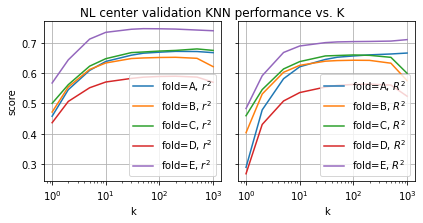

fold A, chosen k: 500
fold B, chosen k: 100
fold C, chosen k: 200
fold D, chosen k: 100
fold E, chosen k: 1000


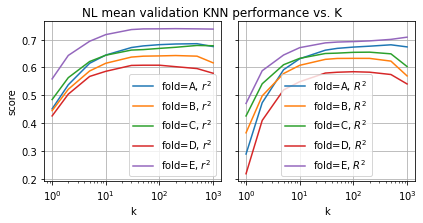

In [ ]:
# plot validation performance for nl center values
plot_knn_val_performance(nls_center_result, labels, title='NL center')
# plot validation performance for nl mean values
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

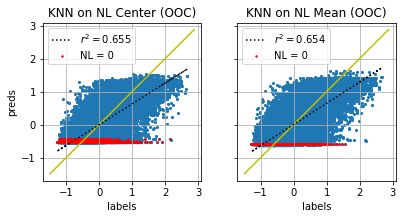

In [ ]:
#plot test results
plot_knn_test(nls_center_result, nls_mean_result, labels,
              nl0_center_mask, nl0_mean_mask, title='OOC')

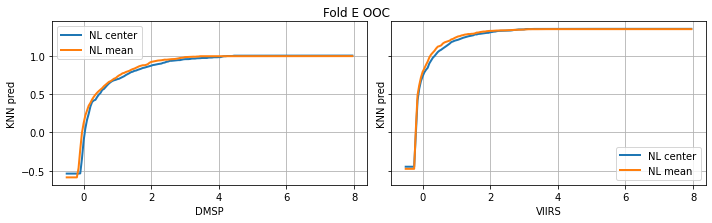

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask, viirs_mask]
    for i in range(2):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='KNN pred')
axs[1].set(xlabel='VIIRS', ylabel='KNN pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E OOC', y=1.02)
fig.tight_layout()
plt.show()

### OOC Keep

In [ ]:
# perform knn using multiple different fractions for keep var and multiple different seeds
for k in [0.05, 0.1, 0.25, 0.5]:
    for s in [123, 456, 789]:
        print(f'== keep: {k}, seed: {s} == ')
        filename = f'test_preds_keep{k}_seed{s}.npz'
        knn_cv_wrapper(
            labels=labels, years=years, nls=nls_center, folds=ooc_folds,
            keep=k, seed=s,
            savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_center', filename))

        knn_cv_wrapper(
            labels=labels, years=years, nls=nls_mean, folds=ooc_folds,
            keep=k, seed=s,
            savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'nls_mean', filename))

== keep: 0.05, seed: 123 == 
test preds	- r^2: 0.637, R^2: 0.632, mse: 0.240, rank: 0.723
test preds	- r^2: 0.642, R^2: 0.637, mse: 0.237, rank: 0.746
== keep: 0.05, seed: 456 == 
test preds	- r^2: 0.637, R^2: 0.634, mse: 0.239, rank: 0.716
test preds	- r^2: 0.638, R^2: 0.634, mse: 0.239, rank: 0.739
== keep: 0.05, seed: 789 == 
test preds	- r^2: 0.645, R^2: 0.642, mse: 0.234, rank: 0.740
test preds	- r^2: 0.646, R^2: 0.642, mse: 0.234, rank: 0.744
== keep: 0.1, seed: 123 == 
test preds	- r^2: 0.642, R^2: 0.640, mse: 0.235, rank: 0.728
test preds	- r^2: 0.648, R^2: 0.646, mse: 0.231, rank: 0.748
== keep: 0.1, seed: 456 == 
test preds	- r^2: 0.645, R^2: 0.644, mse: 0.232, rank: 0.719
test preds	- r^2: 0.648, R^2: 0.647, mse: 0.230, rank: 0.747
== keep: 0.1, seed: 789 == 
test preds	- r^2: 0.650, R^2: 0.650, mse: 0.229, rank: 0.728
test preds	- r^2: 0.653, R^2: 0.651, mse: 0.228, rank: 0.752
== keep: 0.25, seed: 123 == 
test preds	- r^2: 0.650, R^2: 0.649, mse: 0.229, rank: 0.734
test pr

### Incountry

In [ ]:
# perform knn cv wrapper for incountry nls center values
nls_center_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=incountry_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'incountry_nls_center', 'test_preds.npz'))
# perform knn cv wrapper for incountry nls mean values
nls_mean_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=incountry_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_knn', 'incountry_nls_mean', 'test_preds.npz'))

test preds	- r^2: 0.663, R^2: 0.663, mse: 0.220, rank: 0.747
test preds	- r^2: 0.665, R^2: 0.665, mse: 0.219, rank: 0.763


fold A, chosen k: 1000
fold B, chosen k: 100
fold C, chosen k: 100
fold D, chosen k: 200
fold E, chosen k: 1000


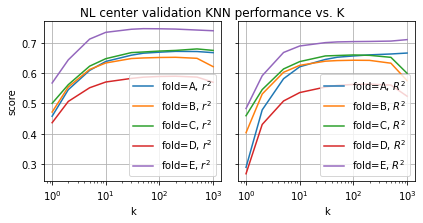

fold A, chosen k: 500
fold B, chosen k: 100
fold C, chosen k: 200
fold D, chosen k: 100
fold E, chosen k: 1000


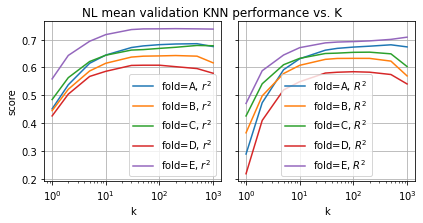

In [ ]:
plot_knn_val_performance(nls_center_result, labels, title='NL center')
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

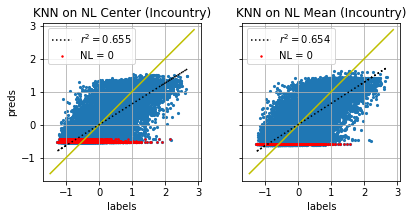

In [ ]:
plot_knn_test(nls_center_result, nls_mean_result, labels,
              nl0_center_mask, nl0_mean_mask, title='Incountry')

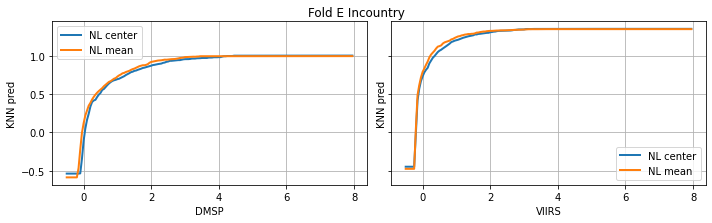

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask, viirs_mask]
    for i in range(2):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='KNN pred')
axs[1].set(xlabel='VIIRS', ylabel='KNN pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E Incountry', y=1.02)
fig.tight_layout()
plt.show()

## GBT on NL

As with the KNN section above, this section uses leave-one-fold-out OOC training, which is not directly comparable to our other leave-one-country-out OOC results.

In [ ]:
def gbt_nl(labels, years, nls_center, train_idxs, test_idxs, max_depth, lr):
    '''

    Args:
        - labels: np.array, shape [N]
        - years: np.array, shape [N]
        - nls_center: np.array, shape [N]
        - splits: dict, split (str) => np.array
        - max_depth: int
        - lr: float, learning rate

    Returns:
        - Prediction
        - Gradient Boosting Regressor for DMSP
        - Gradient Boosting Regressor VIIRS

    '''
    train_nls = nls_center[train_idxs]      # set train data

    # test
    test_nls = nls_center[test_idxs]        # set test data
    test_labels = labels[test_idxs]         # set test labels
    preds = np.zeros_like(test_labels)      # create empty np.array to store predictions

    #set parameters for GradientBoostingRegressor
    params = {  
        'n_estimators': 50,
        'max_depth': max_depth,
        'min_samples_split': 2,
        'learning_rate': lr,
        'loss': 'ls'
    }
    gbt_dmsp = sklearn.ensemble.GradientBoostingRegressor(**params)
    gbt_viirs = sklearn.ensemble.GradientBoostingRegressor(**params)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    # perform  GradientBoostingRegressor for each sensor and return predictions and models
    for mask, model in [(dmsp_mask, gbt_dmsp), (viirs_mask, gbt_viirs)]:
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, gbt_dmsp, gbt_viirs

In [ ]:
def gbt_cv_wrapper(labels, years, nls, folds, keep=1.0, seed=None, savepath=None, verbose=False):
    '''
    Args
        - labels: np.array, shape [N]
        - years: np.array, shape [N]
        - nls: np.array, shape [N]
        - folds: dict, folds[f][split] is a np.array of indices
        - keep: float, fraction of training and validation data to use
        - seed: int, random seed
        - savepath: str, path to save predictions
        - verbose: bool, whether to print out validation performance on each fold

    Returns
        - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
            best models from the last fold
        - test_preds: np.array, shape [N]
        - ks: np.array, shape [K]
        - r2s: np.array, shape [K]
        - R2s: np.array, shape [K]
        - savepath: str, path to save npz file
    '''
    N = len(labels)
    assert len(years) == N
    assert len(nls) == N
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)
    max_depths = [2, 3, 4, 5, 6]
    lrs = [5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
    fold_keys = sorted(folds.keys())
    r2s = np.zeros([len(fold_keys), len(max_depths), len(lrs)])
    R2s = np.zeros([len(fold_keys), len(max_depths), len(lrs)])

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for i, f in enumerate(fold_keys):
        if verbose:
            print(f'Runing fold {f}...')
        test_idxs = folds[f]['test']
        best_models = None

        for j, d in enumerate(max_depths):
            for k, lr in enumerate(lrs):
                train_idxs = folds[f]['train']
                val_idxs = folds[f]['val']

                if keep < 1:
                    if seed is not None:
                        np.random.seed(seed)
                    num_train = int(len(train_idxs) * keep)
                    num_val = int(len(val_idxs) * keep)
                    if num_train < k or num_val < k:
                        continue
                    train_idxs = np.random.choice(
                        train_idxs, size=num_train, replace=False)
                    val_tfrecord_paths = np.random.choice(
                        val_idxs, size=num_val, replace=False)

                val_preds, gbt_dmsp, gbt_viirs = gbt_nl(
                    labels, years, nls, train_idxs=train_idxs,
                    test_idxs=val_idxs, max_depth=d, lr=lr)
                r2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='r2')
                R2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='R2')
                if R2 > np.max(R2s[i]):
                    best_models = (gbt_dmsp, gbt_viirs)
                r2s[i, j, k], R2s[i, j, k] = r2, R2
                if verbose:
                    print(f'fold={f}, depth={d:4d}, lr={lr:0.4f} val_r2={r2:0.4f}, val_R2={R2:0.4f}')

        for i, mask in enumerate([dmsp_mask, viirs_mask]):
            subset_indices = np.intersect1d(np.nonzero(mask)[0], test_idxs)
            test_preds[subset_indices] = best_models[i].predict(nls[subset_indices].reshape(-1, 1))

    evaluate(labels=labels, preds=test_preds, do_print=True, title='test preds')

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, max_depths, lrs, r2s, R2s

def plot_depth_v_lr(depths, lrs, r2s, folds, title=None):
    '''
    Args
        - depths: list of int, length num_depths
        - lrs: list of float, length num_lrs
        - r2s: np.array, shape [num_folds, num_depths, num_lrs]
        - folds: list of str, names of folds
        - title: str
    '''
    lrs, depths = np.meshgrid(lrs, depths)
    lrs = lrs.flatten()
    depths = depths.flatten()

    vmin, vmax = r2s.min(), r2s.max()

    fig, axs = plt.subplots(nrows=1, ncols=len(folds), figsize=[10, 3])
    for i, ax in enumerate(axs):
        f = folds[i]
        j, k = np.nonzero(r2s[i] == np.max(r2s[i]))
        j, k = j[0], k[0]
        d = depths[j]
        lr = lrs[k]
        print(f'fold {f}, chosen depth: {d}, lr: {lr}')
        cax = ax.scatter(x=lrs, y=depths, s=30, c=r2s[i].flatten(), vmin=vmin, vmax=vmax)
        ax.set_title(f'{title}, Fold {f} r^2')

    for ax in axs:
        ax.set_xscale('log')
        ax.set_xlim(left=np.min(lrs)/2, right=np.max(lrs)*2)
        ax.set_xlabel('learning_rate')
        ax.set_ylabel('max_depth')
        ax.grid(True)

    cbar = fig.colorbar(cax)
    fig.tight_layout()
    plt.show()

In [ ]:
# get best results and model for nls center values
nls_center_result = gbt_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_gbt', 'nls_center', 'test_preds.npz'),
    verbose=True)
# get best results and model for nls mean values
nls_mean_result = gbt_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=ooc_folds,
    savepath=os.path.join(LOGS_ROOT_DIR, 'dhs_gbt', 'nls_mean', 'test_preds.npz'),
    verbose=True)

Runing fold A...
fold=A, depth=   2, lr=0.5000 val_r2=0.6619, val_R2=0.6480
fold=A, depth=   2, lr=0.1000 val_r2=0.6718, val_R2=0.6595
fold=A, depth=   2, lr=0.0500 val_r2=0.6714, val_R2=0.6592
fold=A, depth=   2, lr=0.0100 val_r2=0.5981, val_R2=0.4287
fold=A, depth=   2, lr=0.0050 val_r2=0.4560, val_R2=0.2644
fold=A, depth=   2, lr=0.0010 val_r2=0.1237, val_R2=0.0602
fold=A, depth=   3, lr=0.5000 val_r2=0.6543, val_R2=0.6391
fold=A, depth=   3, lr=0.1000 val_r2=0.6709, val_R2=0.6583
fold=A, depth=   3, lr=0.0500 val_r2=0.6697, val_R2=0.6576
fold=A, depth=   3, lr=0.0100 val_r2=0.5932, val_R2=0.4263
fold=A, depth=   3, lr=0.0050 val_r2=0.4553, val_R2=0.2647
fold=A, depth=   3, lr=0.0010 val_r2=0.1244, val_R2=0.0606
fold=A, depth=   4, lr=0.5000 val_r2=0.6413, val_R2=0.6239
fold=A, depth=   4, lr=0.1000 val_r2=0.6681, val_R2=0.6552
fold=A, depth=   4, lr=0.0500 val_r2=0.6678, val_R2=0.6557
fold=A, depth=   4, lr=0.0100 val_r2=0.5926, val_R2=0.4255
fold=A, depth=   4, lr=0.0050 val_r2=0.

fold A, chosen depth: 2, lr: 0.1
fold B, chosen depth: 2, lr: 0.1
fold C, chosen depth: 2, lr: 0.05
fold D, chosen depth: 2, lr: 0.1
fold E, chosen depth: 2, lr: 0.05


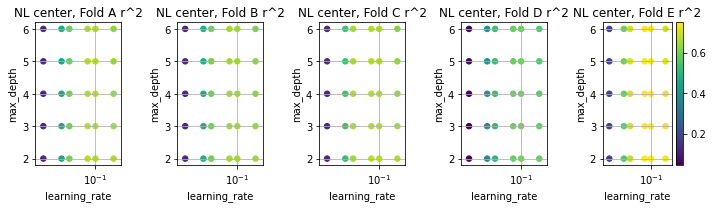

In [ ]:
plot_depth_v_lr(*nls_center_result[2:5], folds=FOLDS, title='NL center')

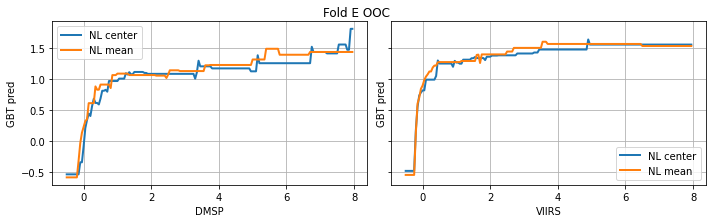

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask, viirs_mask]
    for i in range(2):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='GBT pred')
axs[1].set(xlabel='VIIRS', ylabel='GBT pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E OOC', y=1.02)
fig.tight_layout()
plt.show()

# Ridge Regression on Histograms

- set "missing" DMSP and VIIRS values to 0 (i.e. the mean)
- not sure if this is the most "correct" thing to do, but it's somewhat reasonable approximation

In [ ]:
# standardize to 0 mean and unit variance
num_examples = len(image_hists)
image_hists_mean = np.mean(image_hists, axis=0, dtype=np.float64)
image_hists_std = np.std(image_hists, axis=0, dtype=np.float64)

image_hists_mean[7] = np.mean(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
image_hists_mean[8] = np.mean(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

image_hists_std[7] = np.std(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
image_hists_std[8] = np.std(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

standardized_image_hists = np.zeros(image_hists.shape, dtype=np.float64)
for mask in [dmsp_mask, viirs_mask]:
    standardized_image_hists[mask] = (image_hists[mask] - image_hists_mean) / (image_hists_std + 1e-6)

print(standardized_image_hists.shape)

(19669, 9, 102)


In [ ]:
# split nls by sensors
def split_nls(nls, years):
    '''
    Args
        - nls: np.array, shape [N]
        - years: np.array, shape [N]

    Returns
        - nls_split: np.array, shape [N, 2]
    '''
    N = len(nls)
    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask
    nls_split = np.zeros([N, 2], dtype=np.float32)
    nls_split[dmsp_mask, 0] = nls[dmsp_mask]
    nls_split[viirs_mask, 1] = nls[viirs_mask]
    return nls_split

In [ ]:
#standardize per sensor split
standardized_nls_center = split_nls(nls_center, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    standardized_nls_center[mask, i] -= np.mean(standardized_nls_center[mask, i])
    standardized_nls_center[mask, i] -= np.std(standardized_nls_center[mask, i])

standardized_nls_mean = split_nls(nls_mean, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    standardized_nls_mean[mask, i] -= np.mean(standardized_nls_mean[mask, i])
    standardized_nls_mean[mask, i] -= np.std(standardized_nls_mean[mask, i])

## OOC

ridge_cv performs as follows:

    For every fold F (the test fold):
      1. uses leave-one-fold-out CV on all other folds
         to tune ridge model alpha parameter
      2. using best alpha, trains ridge model on all folds except F
      3. runs trained ridge model on F

    Saves predictions for each fold on test.
        savedir/test_preds_{subset_name}.npz if subset_name is given
        savedir/test_preds.npz otherwise
    Saves ridge regression weights to savedir/ridge_weights.npz
        if save_weight=True

In [2]:
def ridge_ooc_wrapper(img_hists, model_name):
    '''

    Args:
        - img_hists: np.array, shape [N, C, nbins], type int64
        - model_name: str, Name of the model (For print)

    '''
    # perform ridge cv on all locations
    print(model_name)
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name))
    # perform ridge cv only on urban locations
    print(f'== {model_name} urban ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=urban_indices, subset_name='urban')
    # perform ridge cv only on rural locations
    print(f'== {model_name} rural ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1),
        labels=labels, group_labels=country_labels, group_names=COUNTRIES,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=rural_indices, subset_name='rural')

In [ ]:
model_name = 'nlcenter_scalar'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_nls_center)

nlcenter_scalar
Group: angola
best val mse: 0.428, best alpha: 128.0, test mse: 2.242
Group: benin
best val mse: 0.505, best alpha: 8192.0, test mse: 0.384
Group: burkina_faso
best val mse: 0.510, best alpha: 8192.0, test mse: 0.285
Group: cameroon
best val mse: 0.498, best alpha: 8192.0, test mse: 0.581
Group: cote_d_ivoire
best val mse: 0.502, best alpha: 8192.0, test mse: 0.397
Group: democratic_republic_of_congo
best val mse: 0.498, best alpha: 8192.0, test mse: 0.615
Group: ethiopia
best val mse: 0.491, best alpha: 8192.0, test mse: 0.673
Group: ghana
best val mse: 0.491, best alpha: 8192.0, test mse: 0.781
Group: guinea
best val mse: 0.499, best alpha: 8192.0, test mse: 0.585
Group: kenya
best val mse: 0.513, best alpha: 8192.0, test mse: 0.391
Group: lesotho
best val mse: 0.506, best alpha: 8192.0, test mse: 0.368
Group: malawi
best val mse: 0.522, best alpha: 8192.0, test mse: 0.320
Group: mali
best val mse: 0.506, best alpha: 8192.0, test mse: 0.345
Group: mozambique
best val 

In [ ]:
model_name = 'nlmean_scalar'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_nls_mean)

nlmean_scalar
Group: angola
best val mse: 0.429, best alpha: 128.0, test mse: 2.223
Group: benin
best val mse: 0.516, best alpha: 8192.0, test mse: 0.385
Group: burkina_faso
best val mse: 0.521, best alpha: 8192.0, test mse: 0.291
Group: cameroon
best val mse: 0.508, best alpha: 8192.0, test mse: 0.593
Group: cote_d_ivoire
best val mse: 0.512, best alpha: 8192.0, test mse: 0.429
Group: democratic_republic_of_congo
best val mse: 0.508, best alpha: 8192.0, test mse: 0.651
Group: ethiopia
best val mse: 0.502, best alpha: 8192.0, test mse: 0.697
Group: ghana
best val mse: 0.502, best alpha: 8192.0, test mse: 0.798
Group: guinea
best val mse: 0.509, best alpha: 8192.0, test mse: 0.614
Group: kenya
best val mse: 0.524, best alpha: 8192.0, test mse: 0.402
Group: lesotho
best val mse: 0.516, best alpha: 8192.0, test mse: 0.377
Group: malawi
best val mse: 0.532, best alpha: 8192.0, test mse: 0.337
Group: mali
best val mse: 0.516, best alpha: 8192.0, test mse: 0.364
Group: mozambique
best val ms

In [ ]:
model_name = 'rgb_hist'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :3, :])

rgb_hist
Group: angola
best val mse: 0.543, best alpha: 8192.0, test mse: 0.945
Group: benin
best val mse: 0.571, best alpha: 8192.0, test mse: 0.318
Group: burkina_faso
best val mse: 0.558, best alpha: 8192.0, test mse: 0.617
Group: cameroon
best val mse: 0.562, best alpha: 8192.0, test mse: 0.562
Group: cote_d_ivoire
best val mse: 0.561, best alpha: 8192.0, test mse: 0.519
Group: democratic_republic_of_congo
best val mse: 0.561, best alpha: 8192.0, test mse: 0.478
Group: ethiopia
best val mse: 0.541, best alpha: 8192.0, test mse: 0.895
Group: ghana
best val mse: 0.551, best alpha: 8192.0, test mse: 0.860
Group: guinea
best val mse: 0.561, best alpha: 8192.0, test mse: 0.465
Group: kenya
best val mse: 0.562, best alpha: 1024.0, test mse: 0.549
Group: lesotho
best val mse: 0.571, best alpha: 8192.0, test mse: 0.306
Group: malawi
best val mse: 0.584, best alpha: 8192.0, test mse: 0.355
Group: mali
best val mse: 0.566, best alpha: 8192.0, test mse: 0.403
Group: mozambique
best val mse: 0

In [ ]:
model_name = 'rgbnl_hist'
bands = [0, 1, 2, -2, -1]
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, bands, :])

rgbnl_hist
Group: angola
best val mse: 0.228, best alpha: 1024.0, test mse: 0.365
Group: benin
best val mse: 0.234, best alpha: 1024.0, test mse: 0.172
Group: burkina_faso
best val mse: 0.237, best alpha: 1024.0, test mse: 0.131
Group: cameroon
best val mse: 0.227, best alpha: 1024.0, test mse: 0.372
Group: cote_d_ivoire
best val mse: 0.232, best alpha: 1024.0, test mse: 0.210
Group: democratic_republic_of_congo
best val mse: 0.232, best alpha: 1024.0, test mse: 0.231
Group: ethiopia
best val mse: 0.230, best alpha: 1024.0, test mse: 0.284
Group: ghana
best val mse: 0.231, best alpha: 1024.0, test mse: 0.257
Group: guinea
best val mse: 0.233, best alpha: 1024.0, test mse: 0.163
Group: kenya
best val mse: 0.232, best alpha: 1024.0, test mse: 0.237
Group: lesotho
best val mse: 0.234, best alpha: 1024.0, test mse: 0.187
Group: malawi
best val mse: 0.235, best alpha: 1024.0, test mse: 0.199
Group: mali
best val mse: 0.236, best alpha: 1024.0, test mse: 0.134
Group: mozambique
best val mse:

In [ ]:
model_name = 'ms_hist'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :7, :])

ms_hist
Group: angola


KeyboardInterrupt: ignored

In [ ]:
model_name = 'msnl_hist'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_image_hists)

In [ ]:
model_name = 'nl_hist'
ridge_ooc_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, -2:, :])

## Incountry

In [ ]:
def ridge_incountry_wrapper(img_hists, model_name):
    '''

    Args:
        - img_hists: np.array, shape [N, C, nbins], type int64
        - model_name: str, Name of the model (For print)

    '''
    print(model_name)
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name))
    print(f'== {model_name} urban ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=urban_indices, subset_name='urban')
    print(f'== {model_name} rural ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=rural_indices, subset_name='rural')

In [ ]:
model_name = 'incountry_nlcenter_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_nls_center)

incountry_nlcenter_scalar
Group: A
best val mse: 0.497, best alpha: 8192.0, test mse: 0.503
Group: B
best val mse: 0.440, best alpha: 1024.0, test mse: 0.661
Group: C
best val mse: 0.504, best alpha: 8192.0, test mse: 0.476
Group: D
best val mse: 0.503, best alpha: 8192.0, test mse: 0.487
Group: E
best val mse: 0.502, best alpha: 8192.0, test mse: 0.495
saving test preds to: ../logs/dhs_ridge/incountry_nlcenter_scalar/test_preds.npz
== incountry_nlcenter_scalar urban ==
Group: A
best val mse: 0.385, best alpha: 1024.0, test mse: 0.448
Group: B
best val mse: 0.379, best alpha: 1024.0, test mse: 0.466
Group: C
best val mse: 0.411, best alpha: 8192.0, test mse: 0.356
Group: D
best val mse: 0.402, best alpha: 8192.0, test mse: 0.395
Group: E
best val mse: 0.406, best alpha: 8192.0, test mse: 0.392
saving test preds to: ../logs/dhs_ridge/incountry_nlcenter_scalar/test_preds_urban.npz
== incountry_nlcenter_scalar rural ==
Group: A
best val mse: 0.214, best alpha: 16.0, test mse: 0.195
Group:

In [ ]:
model_name = 'incountry_nlmean_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_nls_mean)

incountry_nlmean_scalar
Fold: A
best val mse: 0.503, best alpha: 1024.0, test mse: 0.478
Fold: B
best val mse: 0.436, best alpha: 128.0, test mse: 0.748
Fold: C
best val mse: 0.520, best alpha: 8192.0, test mse: 0.493
Fold: D
best val mse: 0.516, best alpha: 1024.0, test mse: 0.459
Fold: E
best val mse: 0.512, best alpha: 1024.0, test mse: 0.449
saving test preds to: ../logs/dhs_ridge/incountry_nlmean_scalar/test_preds.npz
== incountry_nlmean_scalar urban ==
Fold: A
best val mse: 0.384, best alpha: 1024.0, test mse: 0.448
Fold: B
best val mse: 0.376, best alpha: 128.0, test mse: 0.537
Fold: C
best val mse: 0.410, best alpha: 1024.0, test mse: 0.353
Fold: D
best val mse: 0.405, best alpha: 1024.0, test mse: 0.382
Fold: E
best val mse: 0.409, best alpha: 1024.0, test mse: 0.364
saving test preds to: ../logs/dhs_ridge/incountry_nlmean_scalar/test_preds_urban.npz
== incountry_nlmean_scalar rural ==
Fold: A
best val mse: 0.219, best alpha: 128.0, test mse: 0.197
Fold: B
best val mse: 0.223,

In [ ]:
model_name = 'incountry_rgb_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :3, :])

incountry_rgb_hist
Fold: A
best val mse: 0.522, best alpha: 1024.0, test mse: 0.561
Fold: B
best val mse: 0.533, best alpha: 1024.0, test mse: 0.531
Fold: C
best val mse: 0.544, best alpha: 1024.0, test mse: 0.504
Fold: D
best val mse: 0.527, best alpha: 1024.0, test mse: 0.544
Fold: E
best val mse: 0.539, best alpha: 1024.0, test mse: 0.507
saving test preds to: ../logs/dhs_ridge/incountry_rgb_hist/test_preds.npz
== incountry_rgb_hist urban ==
Fold: A
best val mse: 0.391, best alpha: 8192.0, test mse: 0.469
Fold: B
best val mse: 0.397, best alpha: 8192.0, test mse: 0.434
Fold: C
best val mse: 0.416, best alpha: 8192.0, test mse: 0.373
Fold: D
best val mse: 0.398, best alpha: 1024.0, test mse: 0.428
Fold: E
best val mse: 0.421, best alpha: 8192.0, test mse: 0.353
saving test preds to: ../logs/dhs_ridge/incountry_rgb_hist/test_preds_urban.npz
== incountry_rgb_hist rural ==
Fold: A
best val mse: 0.235, best alpha: 1024.0, test mse: 0.217
Fold: B
best val mse: 0.242, best alpha: 1024.0, t

In [ ]:
model_name = 'incountry_rgbnl_hist'
bands = [0, 1, 2, -2, -1]
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, bands, :])

incountry_rgbnl_hist
Fold: A
best val mse: 0.222, best alpha: 1024.0, test mse: 0.222
Fold: B
best val mse: 0.222, best alpha: 1024.0, test mse: 0.236
Fold: C
best val mse: 0.230, best alpha: 1024.0, test mse: 0.211
Fold: D
best val mse: 0.222, best alpha: 1024.0, test mse: 0.222
Fold: E
best val mse: 0.224, best alpha: 1024.0, test mse: 0.213
saving test preds to: ../logs/dhs_ridge/incountry_rgbnl_hist/test_preds.npz
== incountry_rgbnl_hist urban ==
Fold: A
best val mse: 0.283, best alpha: 1024.0, test mse: 0.309
Fold: B
best val mse: 0.283, best alpha: 1024.0, test mse: 0.323
Fold: C
best val mse: 0.307, best alpha: 1024.0, test mse: 0.245
Fold: D
best val mse: 0.280, best alpha: 1024.0, test mse: 0.311
Fold: E
best val mse: 0.299, best alpha: 1024.0, test mse: 0.246
saving test preds to: ../logs/dhs_ridge/incountry_rgbnl_hist/test_preds_urban.npz
== incountry_rgbnl_hist rural ==
Fold: A
best val mse: 0.157, best alpha: 1024.0, test mse: 0.154
Fold: B
best val mse: 0.161, best alpha:

In [ ]:
model_name = 'incountry_ms_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :7, :])

incountry_ms_hist
Fold: A
best val mse: 0.400, best alpha: 1024.0, test mse: 0.491
Fold: B
best val mse: 0.438, best alpha: 1024.0, test mse: 0.394
Fold: C
best val mse: 0.426, best alpha: 1024.0, test mse: 0.399
Fold: D
best val mse: 0.423, best alpha: 1024.0, test mse: 0.422
Fold: E
best val mse: 0.433, best alpha: 1024.0, test mse: 0.382
saving test preds to: ../logs/dhs_ridge/incountry_ms_hist/test_preds.npz
== incountry_ms_hist urban ==
Fold: A
best val mse: 0.353, best alpha: 1024.0, test mse: 0.428
Fold: B
best val mse: 0.369, best alpha: 8192.0, test mse: 0.371
Fold: C
best val mse: 0.375, best alpha: 8192.0, test mse: 0.345
Fold: D
best val mse: 0.361, best alpha: 1024.0, test mse: 0.388
Fold: E
best val mse: 0.383, best alpha: 8192.0, test mse: 0.319
saving test preds to: ../logs/dhs_ridge/incountry_ms_hist/test_preds_urban.npz
== incountry_ms_hist rural ==
Fold: A
best val mse: 0.222, best alpha: 8192.0, test mse: 0.210
Fold: B
best val mse: 0.232, best alpha: 8192.0, test m

In [ ]:
model_name = 'incountry_msnl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists)

incountry_msnl_hist
Fold: A
best val mse: 0.220, best alpha: 1024.0, test mse: 0.235
Fold: B
best val mse: 0.227, best alpha: 1024.0, test mse: 0.232
Fold: C
best val mse: 0.231, best alpha: 1024.0, test mse: 0.216
Fold: D
best val mse: 0.226, best alpha: 1024.0, test mse: 0.218
Fold: E
best val mse: 0.227, best alpha: 1024.0, test mse: 0.214
saving test preds to: ../logs/dhs_ridge/incountry_msnl_hist/test_preds.npz
== incountry_msnl_hist urban ==
Fold: A
best val mse: 0.285, best alpha: 1024.0, test mse: 0.324
Fold: B
best val mse: 0.292, best alpha: 1024.0, test mse: 0.330
Fold: C
best val mse: 0.317, best alpha: 8192.0, test mse: 0.278
Fold: D
best val mse: 0.290, best alpha: 1024.0, test mse: 0.313
Fold: E
best val mse: 0.313, best alpha: 1024.0, test mse: 0.249
saving test preds to: ../logs/dhs_ridge/incountry_msnl_hist/test_preds_urban.npz
== incountry_msnl_hist rural ==
Fold: A
best val mse: 0.155, best alpha: 1024.0, test mse: 0.160
Fold: B
best val mse: 0.163, best alpha: 1024

In [ ]:
model_name = 'incountry_nl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, -2:, :])

incountry_nl_hist
Fold: A
best val mse: 0.227, best alpha: 1024.0, test mse: 0.223
Fold: B
best val mse: 0.223, best alpha: 1024.0, test mse: 0.245
Fold: C
best val mse: 0.232, best alpha: 128.0, test mse: 0.215
Fold: D
best val mse: 0.226, best alpha: 1024.0, test mse: 0.225
Fold: E
best val mse: 0.226, best alpha: 128.0, test mse: 0.225
saving test preds to: ../logs/dhs_ridge/incountry_nl_hist/test_preds.npz
== incountry_nl_hist urban ==
Fold: A
best val mse: 0.286, best alpha: 1024.0, test mse: 0.296
Fold: B
best val mse: 0.278, best alpha: 1024.0, test mse: 0.328
Fold: C
best val mse: 0.304, best alpha: 1024.0, test mse: 0.246
Fold: D
best val mse: 0.278, best alpha: 1024.0, test mse: 0.307
Fold: E
best val mse: 0.294, best alpha: 1024.0, test mse: 0.251
saving test preds to: ../logs/dhs_ridge/incountry_nl_hist/test_preds_urban.npz
== incountry_nl_hist rural ==
Fold: A
best val mse: 0.162, best alpha: 128.0, test mse: 0.160
Fold: B
best val mse: 0.164, best alpha: 128.0, test mse: 

# KNN on Histograms


knn_cv_opt performs as follows:
```
Similar to knn_cv(), but pre-computes a distance matrix to use for all folds.

    For every fold F (the test fold):
      1. uses leave-one-fold-out CV on all other folds
         to tune KNN k parameter
      2. using best k, trains KNN model on all folds except F
      3. runs trained ridge model on F

    Saves predictions for each fold on test.
        savedir/test_preds_{subset_name}.npz if subset_name is given
        savedir/test_preds.npz otherwise
```



## OOC

In [ ]:
def knn_ooc_wrapper(img_hists, model_name, years=None):
    '''

    Args:
        - img_hists: np.array, shape [N, C, nbins], type int64
        - model_name: str, Name of the model (For print)
        - years: np.array, shape [N], type int32, year for each image

    '''
    savedir = os.path.join(LOGS_ROOT_DIR, 'dhs_knn', model_name)
    features = img_hists.reshape(len(img_hists), -1)

    print(model_name)
    if years is None:
        knn_cv_opt(features=features, labels=labels,
                   group_labels=country_labels, group_names=COUNTRIES,
                   savedir=savedir)
    else:  # split DMSP and VIIRS and perform knn_cb_opt for each split
        filename = 'test_preds.npz'
        npz_path = os.path.join(savedir, filename)
        # assert not os.path.exists(npz_path)

        dmsp_mask = years < 2012
        viirs_mask = ~dmsp_mask
        test_preds = np.zeros(len(image_hists), dtype=np.float32)
        for mask in [dmsp_mask, viirs_mask]:
            test_preds[mask] = knn_cv_opt(
                features=features[mask], labels=labels[mask],
                group_labels=country_labels[mask], group_names=COUNTRIES)

        os.makedirs(savedir, exist_ok=True)
        save_dict = {
            'labels': labels,
            'test_preds': test_preds
        }
        print('saving test preds to:', npz_path)
        np.savez_compressed(npz_path, **save_dict)

        evaluate(labels=labels, preds=test_preds, do_print=True,
                 title='DMSP and VIIRS test preds')

In [ ]:
model_name = 'nlcenter_scalar'
knn_ooc_wrapper(model_name=model_name, img_hists=nls_center, years=years)

In [ ]:
model_name = 'nlmean_scalar'
knn_ooc_wrapper(model_name=model_name, img_hists=nls_mean, years=years)

In [ ]:
model_name = 'nl_hist'
knn_ooc_wrapper(model_name=model_name, img_hists=image_hists[:, -2:, :], years=years)

## Incountry

In [ ]:
def knn_incountry_wrapper(img_hists, model_name, years=None):
    '''

    Args:
        - img_hists: np.array, shape [N, C, nbins], type int64
        - model_name: str, Name of the model (For print)
        - years: np.array, shape [N], type int32, year for each image

    '''
    savedir = os.path.join(LOGS_ROOT_DIR, 'dhs_knn', model_name)
    features = img_hists.reshape(len(img_hists), -1)

    print(model_name)
    if years is None:
        knn_cv_opt(features=features, labels=labels,
                   group_labels=incountry_group_labels, group_names=FOLDS,
                   savedir=savedir)
    else:  # split DMSP and VIIRS
        filename = 'test_preds.npz'
        npz_path = os.path.join(savedir, filename)
        # assert not os.path.exists(npz_path)

        dmsp_mask = years < 2012
        viirs_mask = ~dmsp_mask
        test_preds = np.zeros(len(image_hists), dtype=np.float32)
        for mask in [dmsp_mask, viirs_mask]:
            test_preds[mask] = knn_cv_opt(
                features=features[mask], labels=labels[mask],
                group_labels=incountry_group_labels[mask], group_names=FOLDS)

        os.makedirs(savedir, exist_ok=True)
        save_dict = {
            'labels': labels,
            'test_preds': test_preds
        }
        print('saving test preds to:', npz_path)
        np.savez_compressed(npz_path, **save_dict)

        evaluate(labels=labels, preds=test_preds, do_print=True,
                 title='DMSP and VIIRS test preds')

In [ ]:
model_name = 'incountry_nlcenter_scalar'
knn_incountry_wrapper(model_name=model_name, img_hists=nls_center, years=years)

incountry_nlcenter_scalar
Pre-computing distance matrix... took 0.51 seconds.
Group: A
best val mse: 0.214, best k: 256, test mse: 0.196
Group: B
best val mse: 0.205, best k: 256, test mse: 0.225
Group: C
best val mse: 0.210, best k: 128, test mse: 0.209
Group: D
best val mse: 0.211, best k: 256, test mse: 0.201
Group: E
best val mse: 0.206, best k: 128, test mse: 0.211
Pooled test preds	- r^2: 0.660, R^2: 0.658, mse: 0.208, rank: 0.594
Pre-computing distance matrix... took 1.38 seconds.
Group: A
best val mse: 0.224, best k: 256, test mse: 0.248
Group: B
best val mse: 0.227, best k: 512, test mse: 0.233
Group: C
best val mse: 0.229, best k: 256, test mse: 0.224
Group: D
best val mse: 0.227, best k: 256, test mse: 0.232
Group: E
best val mse: 0.234, best k: 256, test mse: 0.206
Pooled test preds	- r^2: 0.650, R^2: 0.650, mse: 0.228, rank: 0.736
saving test preds to: ../logs/dhs_knn/incountry_nlcenter_scalar/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.662, R^2: 0.662, mse: 0.221, r

In [ ]:
model_name = 'incountry_nlmean_scalar'
knn_incountry_wrapper(model_name=model_name, img_hists=nls_mean, years=years)

incountry_nlmean_scalar
Pre-computing distance matrix... took 0.52 seconds.
Group: A
best val mse: 0.203, best k: 128, test mse: 0.187
Group: B
best val mse: 0.192, best k: 128, test mse: 0.227
Group: C
best val mse: 0.206, best k: 256, test mse: 0.195
Group: D
best val mse: 0.204, best k: 256, test mse: 0.197
Group: E
best val mse: 0.200, best k: 128, test mse: 0.196
Pooled test preds	- r^2: 0.671, R^2: 0.670, mse: 0.201, rank: 0.666
Pre-computing distance matrix... took 1.37 seconds.
Group: A
best val mse: 0.225, best k: 256, test mse: 0.249
Group: B
best val mse: 0.227, best k: 512, test mse: 0.237
Group: C
best val mse: 0.230, best k: 512, test mse: 0.221
Group: D
best val mse: 0.228, best k: 512, test mse: 0.234
Group: E
best val mse: 0.235, best k: 256, test mse: 0.209
Pooled test preds	- r^2: 0.648, R^2: 0.648, mse: 0.229, rank: 0.749
saving test preds to: ../logs/dhs_knn/incountry_nlmean_scalar/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.665, R^2: 0.665, mse: 0.219, rank:

In [ ]:
model_name = 'incountry_nl_hist'
knn_incountry_wrapper(model_name=model_name, img_hists=image_hists[:, -2:, :], years=years)

incountry_nl_hist
Pre-computing distance matrix... took 3.44 seconds.
Group: A
best val mse: 0.201, best k: 128, test mse: 0.185
Group: B
best val mse: 0.191, best k: 128, test mse: 0.220
Group: C
best val mse: 0.207, best k: 64, test mse: 0.185
Group: D
best val mse: 0.203, best k: 64, test mse: 0.190
Group: E
best val mse: 0.197, best k: 64, test mse: 0.202
Pooled test preds	- r^2: 0.679, R^2: 0.678, mse: 0.196, rank: 0.673
Pre-computing distance matrix... took 12.46 seconds.
Group: A
best val mse: 0.216, best k: 512, test mse: 0.239
Group: B
best val mse: 0.219, best k: 128, test mse: 0.229
Group: C
best val mse: 0.219, best k: 128, test mse: 0.207
Group: D
best val mse: 0.218, best k: 256, test mse: 0.226
Group: E
best val mse: 0.222, best k: 256, test mse: 0.204
Pooled test preds	- r^2: 0.662, R^2: 0.661, mse: 0.220, rank: 0.756
saving test preds to: ../logs/dhs_knn/incountry_nl_hist/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.676, R^2: 0.676, mse: 0.212, rank: 0.764
